In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [3]:
with open('./turing_Brusselator.npy', 'rb') as f:
    sol = np.load(f)

In [4]:
torch.manual_seed(42)
np.random.seed(42)

D_U = 0.0016
D_V = 0.0135

x = torch.linspace(0, 0.5, 32, device=dev_str)
y = torch.linspace(0, 0.5, 32, device=dev_str)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
data_X = data_X.detach().clone()
data_X.requires_grad = True


data_x = torch.linspace(0, 0.5, 128).to(device)
data_y = torch.linspace(0, 0.5, 128).to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
physics_X = torch.vstack([X.flatten(), Y.flatten()]).T
# To turn the tensor to a leaf node, we detach and clone it here
physics_X = physics_X.detach().clone()
physics_X.requires_grad = True

data_U = torch.from_numpy(sol[0, :, :].flatten())
data_V = torch.from_numpy(sol[1, :, :].flatten())
data_f = torch.vstack([data_U, data_V]).T.to(device)



A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
#A, B = 4.5, 13.29
sampled_As = []
B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=f"{device.type}:{device.index}"))
sampled_Bs = []




lb = torch.tensor([0., 0.]).to(device)
ub = torch.tensor([0.5, 0.5]).to(device)
model = Net_dense_normalised([2, 1024, 1024, 2], lb, ub).to(device)

optimizer = torch.optim.Adam([
                {'params': model.parameters()},
                {'params': [A, B], 'lr': 0.1}
            ], lr=1e-4, weight_decay=0.0001)
epochs = 1000000
loss_data = 0.0
lambda_data = 1.0#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#1.0
loss_physics = 0.0
lambda_physics = 0.1#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#5e-3

losses = np.zeros((2, epochs))

for i in range(epochs):
    optimizer.zero_grad()

    #################################
    # data loss
    data_f_hat = model(data_X).squeeze()
    loss_data = torch.mean((data_f - data_f_hat)**2)

    #################################
    # boundary loss
    # boundary_f_hat = model(boundary_X).squeeze()
    # loss_boundary = torch.mean((boundary_f - boundary_f_hat)**2)

    #################################
    # physics derivatives
    physics_f = model(physics_X).squeeze()
    U = physics_f[:,0]
    V = physics_f[:,1]
    dxy  = torch.autograd.grad(physics_f, physics_X, torch.ones_like(physics_f), create_graph=True)[0]# computes dy/dx
    dx, dy = dxy[:,0], dxy[:,1]
    dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx),  create_graph=True)[0]# computes d^2u/dx^2
    dx2 =  dxy2[:,0]
    dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy),  create_graph=True)[0]# computes d^2u/dy^2
    dy2 =  dyx2[:,1]
    laplacian = dx2 + dy2
        
    FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
    FV = torch.exp(B) * U - U*U*V
    
    dudt = D_U * laplacian + FU
    dvdt = D_V * laplacian + FV
    ################################
    # physics loss
    # Construct the physics loss here
    loss_physics = torch.mean(dudt**2 + dvdt**2)    
    
    total_loss = (
        +lambda_data*loss_data
        +lambda_physics*loss_physics        
                    )
    
    
    total_loss.backward(retain_graph=True)
    
    optimizer.step()
    
    losses[:,i] = (loss_data.item(), loss_physics.item())
    sampled_As.append(A.item())
    sampled_Bs.append(B.item())
    
    
    if i%20000 == 0:
        print(f"Epoch: {i}")
        print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
        print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")


Epoch: 0
loss data: 20.647421, loss physics: 5.909158
A: 2.4596, B: 3.0042
Epoch: 20000
loss data: 4.155286, loss physics: 6.165624
A: 5.9008, B: 11.2130
Epoch: 40000
loss data: 0.788036, loss physics: 2.083602
A: 12.0006, B: 11.3978
Epoch: 60000
loss data: 0.472204, loss physics: 1.329903
A: 10.9593, B: 10.8524
Epoch: 80000
loss data: 0.393264, loss physics: 0.883884
A: 10.6495, B: 10.7118
Epoch: 100000
loss data: 0.353926, loss physics: 1.572135
A: 10.6551, B: 10.6628
Epoch: 120000
loss data: 0.328552, loss physics: 0.672744
A: 10.5798, B: 10.7038
Epoch: 140000
loss data: 0.310094, loss physics: 0.674905
A: 10.4945, B: 10.6717
Epoch: 160000
loss data: 0.293726, loss physics: 0.870339
A: 10.5331, B: 10.7382
Epoch: 180000
loss data: 0.282400, loss physics: 0.970880
A: 10.6520, B: 10.7726
Epoch: 200000
loss data: 0.272035, loss physics: 0.535344
A: 10.7429, B: 10.8263
Epoch: 220000
loss data: 0.263586, loss physics: 0.519993
A: 10.7190, B: 10.8169
Epoch: 240000
loss data: 0.256153, loss

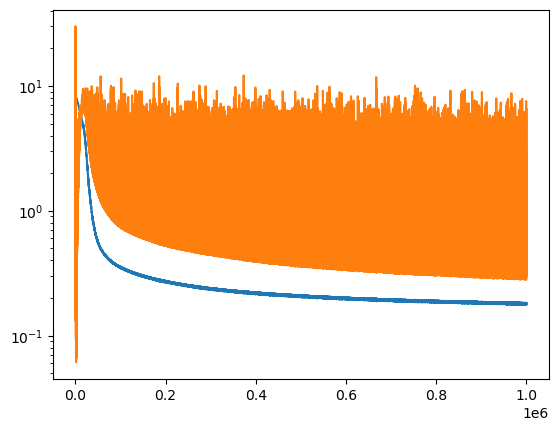

11.36351746019156 11.241809576084544 999511


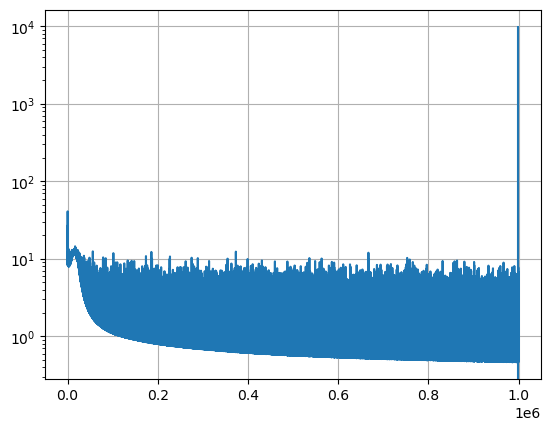

In [5]:

plt.plot(losses[0,:])
plt.plot(losses[1,:])
plt.yscale('log'); plt.show()
plt.plot(np.sum(losses, axis=0))

index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
plt.yscale('log'); plt.vlines(index, 0, 10000);plt.grid();

plt.show()


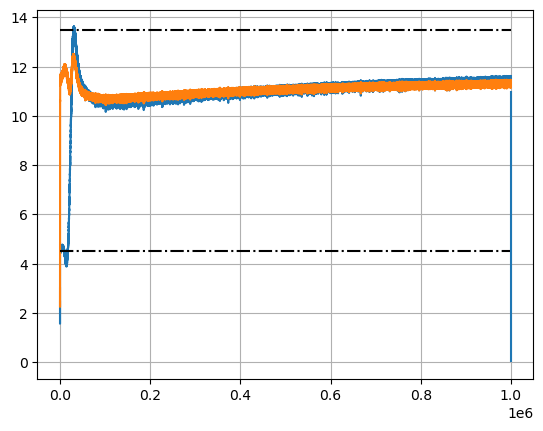

11.36351746019156 11.241809576084544 999511
11.478568210233393 11.294330894106821


In [6]:
plt.plot(np.exp(sampled_As))
plt.plot(np.exp(sampled_Bs))
plt.hlines(4.5, 0,epochs, linestyles='-.', color='black')
plt.hlines(13.5, 0,epochs, linestyles='-.', color='black')
plt.vlines(index, 0, 11);plt.grid()
plt.show()
index = np.argmin(np.sum(losses, axis=0)[20:])
print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))

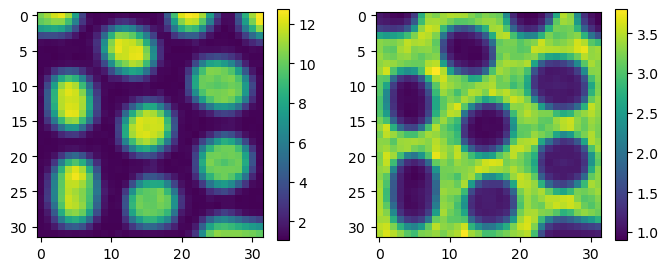

In [7]:
solution = model(data_X).cpu().detach()
U_hat = solution[:, 0].reshape((32, 32))
V_hat = solution[:, 1].reshape((32, 32))
index = -1
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(U_hat)
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(V_hat)
plt.colorbar(shrink=.75)
plt.show()

In [8]:
torch.mean(dudt**2), torch.mean(dvdt**2) 

(tensor(0.3006, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(0.1242, device='cuda:1', grad_fn=<MeanBackward0>))